# Questions 

1) Overlaying to screen data, and/or DEGS. I think we are particulary interested in repressors that go down with hypothermia or activators that go up with hypothermia 
2) might be interesting to plot individual plots for known cold induced genes (CIRBP, RBM3; SMYD5) and see which other genes mirror or are opposite

# Import, options

In [30]:
import numpy, seaborn, pandas
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api

from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress

In [31]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [32]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# Data Download

In [33]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [34]:
#data DEseq HEK293 significant ones
df_annotated = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv',
                               sep = ',')
print(df_annotated.shape, '\n', df_annotated.columns)
df_annotated.head(3)

(2405, 26) 
 Index(['Accession', 'Protein', 'Gene', 'Coverage [%]', '# Peptides',
       'Ctrl_BR1', 'Ctrl_BR2', 'Ctrl_BR3', '3h_BR1', '3h_BR2', '3h_BR3',
       '6h_BR1', '6h_BR2', '6h_BR3', '9h_BR1', '9h_BR2', '9h_BR3', '12h_BR1',
       '12h_BR2', '12h_BR3', '16h_BR1', '16h_BR2', '16h_BR3', 'F.stat',
       'p.value', 'Neglog10p'],
      dtype='object')


,Accession,Protein,Gene,Coverage [%],# Peptides,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,...,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3,F.stat,p.value,Neglog10p
0,Q9Y2L1,Exosome complex exonuclease RRP44,DIS3,6,4,92.2,96.5,92.9,96.6,87.0,...,103.2,102.0,103.0,105.8,102.4,117.6,115.5,11.787,0.000272,3.5657
1,Q6PKG0,La-related protein 1,LARP1,11,10,99.6,103.3,103.5,107.7,106.6,...,99.1,95.3,99.7,93.3,94.8,92.5,93.2,10.947,0.000386,3.4138
2,P60709,"Actin, cytoplasmic 1",ACTB,71,29,100.0,101.7,100.9,107.7,107.1,...,98.2,96.5,93.9,91.1,99.1,100.4,105.6,10.507,0.000467,3.3304


# Data transformation

In [35]:
# Only select expression columns
df = df_annotated.set_index('Gene')
df = df.iloc[:,4:-3]
df.head(2)

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
DIS3,92.2,96.5,92.9,96.6,87.0,97.6,91.6,92.3,90.3,107.6,105.8,103.2,102.0,103.0,105.8,102.4,117.6,115.5
LARP1,99.6,103.3,103.5,107.7,106.6,103.5,103.5,106.4,101.5,94.0,102.6,99.1,95.3,99.7,93.3,94.8,92.5,93.2


## To Zscore for heatmap

In [36]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.columns = df_zscore.columns.str.split('_').str[0]
df_zscore.head(2)

,Ctrl,Ctrl,Ctrl,3h,3h,3h,6h,6h,6h,9h,9h,9h,12h,12h,12h,16h,16h,16h
Gene,,,,,,,,,,,,,,,,,,
DIS3,-0.653263,-0.239042,-0.955599,-0.256279,-1.296774,-0.271000,-1.192699,-0.682300,-1.273195,0.983209,0.380976,0.320070,0.272872,0.425982,0.622966,0.159868,1.382528,1.440664
LARP1,-0.020087,0.552889,0.599936,0.658457,0.911576,0.520616,0.579019,0.563896,0.331780,-0.781334,0.066175,-0.133731,-0.542082,-0.073251,-0.746845,-0.461492,-0.815508,-0.771343


In [37]:
# median instead of the separate triplicate
## Have median of the triplicate
df_zscore = df_zscore.assign(_ctl= (df_zscore[['Ctrl']].median(axis=1)),
                             _3h= (df_zscore[['3h']].median(axis=1)),
                             _6h= (df_zscore[['6h']].median(axis=1)),
                             _9h= (df_zscore[['9h']].median(axis=1)),
                             _12h= (df_zscore[['12h']].median(axis=1)),
                             _16h= (df_zscore[['16h']].median(axis=1)) )

df_zscore = df_zscore.iloc[:,-6:]
print(df_zscore)

            _ctl       _3h       _6h       _9h      _12h      _16h
Gene                                                              
DIS3   -0.653263 -0.271000 -1.192699  0.380976  0.425982  1.382528
LARP1   0.552889  0.658457  0.563896 -0.133731 -0.542082 -0.771343
ACTB    0.218390  0.658457  0.400358 -0.729436 -0.950691 -0.109933
PSMA2   0.277089  0.869464  0.528543 -0.709283 -0.516717 -0.632473
PRRC1   0.587827  1.070722  0.919315 -1.104490 -1.052948 -0.281625
...          ...       ...       ...       ...       ...       ...
RPL22   0.321114 -0.083159  0.519466 -0.041783  0.031208 -0.158988
NOC2L  -0.353929 -0.237668 -0.112454  0.256632  0.053125  0.121395
PSME1   0.042292 -0.412855 -0.327406  0.054430 -0.058123 -0.265458
EPRS1  -0.016408 -0.113730  0.177033  0.230683  0.029602 -0.412437
IMPDH2  0.098694  0.032742  0.057925  0.021225  0.153673 -0.436965

[2405 rows x 6 columns]


## Linregress 

In [38]:
# Regression is about time. So, exclude 37°C to keep 32°C and the time points 
df_linregress = df.copy()

##Change df name as numeric to run linregress - 3,3,3 because of triplicate of 3 hours.
df_linregress.columns = [0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16, 16]
print(df_linregress.columns)

## LinRegress Slope (output: slope, intercept, rvalue, pvalue)
df_linregress = df_linregress.assign(slope = (df_linregress.apply(lambda row: linregress(row.index, row.values).slope, axis=1)),
                                     rvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).rvalue, axis=1)),
                                     pvalue = (df_linregress.apply(lambda row: linregress(row.index, row.values).pvalue, axis=1)))

# Only select linregress values
df_linregress = df_linregress.iloc[:,-3:]
df_linregress.head(5)

Index([0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 16, 16, 16], dtype='int64')


,slope,rvalue,pvalue
Gene,,,
DIS3,1.224167,0.793442,0.000085
LARP1,-0.711667,-0.778966,0.000139
ACTB,-0.336410,-0.386037,0.113583
PSMA2,-0.592244,-0.580626,0.011519
PRRC1,-0.672885,-0.425001,0.078723


### Selection of the Significant Linregress proteins

In [45]:
# adjusted p_value 
sign_answer, adj_pvalue, c , d  = multipletests(df_linregress['pvalue'], alpha = 0.05, method='fdr_bh')
df_linregress['adj_pvalue'] = adj_pvalue

# Select the proteins with significant Linregress nonAdj pavlue
signif_nonAjd_linregress_proteins = list(df_linregress[df_linregress['pvalue'] < 0.05].index)
print(f'on the {len(df_linregress)} proteins, {len(signif_nonAjd_linregress_proteins)} have significant linregress (non adjusted)')

# Select the proteins with significant Linregress Adjusted pvalue
adjPvalue_signif_linregress_proteins = list(df_linregress[df_linregress['adj_pvalue'] < 0.05].index)
print(f'\non the {len(df_linregress)} proteins, {len(adjPvalue_signif_linregress_proteins)} have adjusted significant linregress:')

print(adjPvalue_signif_linregress_proteins)

on the 2405 proteins, 448 have significant linregress (non adjusted)

on the 2405 proteins, 11 have adjusted significant linregress:
[0, 1, 5, 11, 12, 13, 25, 36, 54, 60, 70]


### Selection of the Significant Linregress proteins with Rvalue > 0.6 (abs)

In [40]:
# Deeper visualization of the Rvalue of all the significant linregress proteins
values = df_linregress[df_linregress.index.isin(signif_nonAjd_linregress_proteins)].rvalue
bin_edges = numpy.arange(-1, 1, 0.1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i].round(1)} to {edges[i+1].round(1)}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

        Interval  Count
0   -1.0 to -0.9      0
1   -0.9 to -0.8      0
2   -0.8 to -0.7      7
3   -0.7 to -0.6     25
4   -0.6 to -0.5     64
5   -0.5 to -0.4     30
6   -0.4 to -0.3      0
7   -0.3 to -0.2      0
8   -0.2 to -0.1      0
9   -0.1 to -0.0      0
10   -0.0 to 0.1      0
11    0.1 to 0.2      0
12    0.2 to 0.3      0
13    0.3 to 0.4      0
14    0.4 to 0.5     64
15    0.5 to 0.6    161
16    0.6 to 0.7     72
17    0.7 to 0.8     21
18    0.8 to 0.9      4


In [41]:
high_Rval_prot = df_linregress[(df_linregress['rvalue']< -0.6) |(df_linregress['rvalue'] > 0.6) ].index
len(high_Rval_prot)

129

In [42]:
# # Save the list of significant linregress proteins for Overlapping
# numpy.savetxt(file_directory+"3) output/Proteomics/signif_nonAjd_linregress_proteins.txt", 
#               signif_nonAjd_linregress_proteins, delimiter="\t", fmt="% s")

# # Save the list of significant linregress proteins for Overlapping
# numpy.savetxt(file_directory+"3) output/Proteomics/adjPvalue_signif_linregress_proteins.txt", 
#               adjPvalue_signif_linregress_proteins, delimiter="\t", fmt="% s")

# # Save the list of significant linregress proteins for Overlapping
# numpy.savetxt(file_directory+"3) output/Proteomics/high_Rval_prot_linregress_proteins.txt", 
#               high_Rval_prot, delimiter="\t", fmt="% s")

# Methods

## Slope of all the proteins identified

In [46]:
df_linregress.reset_index(inplace = True)

#define the colors
colors = ['blue' if x < -0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'red' if x > 0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'black' if x > -0.5 and x < 0.5
          else 'grey' for x, y in zip(df_linregress['slope'], 
                                      df_linregress['adj_pvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
grey_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

2405 



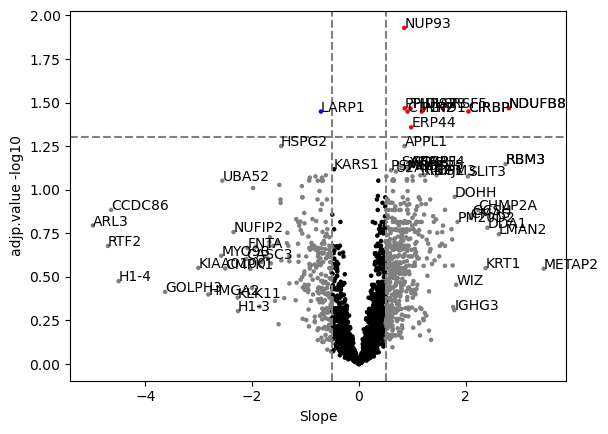

In [47]:
# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
top_pvalue = df_linregress.sort_values(by='adj_pvalue', ascending=True).head(25)
top_neg_slope = df_linregress.sort_values(by='slope', ascending=True).head(15)
top_pos_slope = df_linregress.sort_values(by='slope', ascending=False).head(15)

print(len(df_linregress), '\n')
plt.scatter(x=df_linregress['slope'], 
            y=df_linregress['adj_pvalue'].apply(lambda x:-numpy.log10(x)),
            s=5,
            c = colors)

plt.xlabel("Slope")
plt.ylabel("adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_pvalue.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.axvline(-0.5,color="grey",linestyle="--")
plt.axvline(0.5,color="grey",linestyle="--")

# title_file = 'volcano_proteomic_slope'
plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_slope_proteomics_adjpval'+'.svg')

In [48]:
#define the colors
colors = ['blue' if x < -0.6 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'red' if x > 0.6 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'black' if x > -0.6 and x < 0.6
          else 'grey' for x, y in zip(df_linregress['rvalue'], 
                                      df_linregress['adj_pvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
grey_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

129


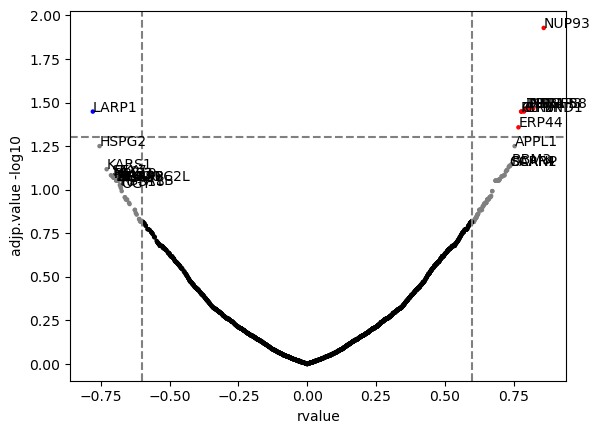

In [49]:
# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
df_linregress_high_Rval = df_linregress[df_linregress['Gene'].isin(high_Rval_prot)]
print(len(df_linregress_high_Rval))

top_neg_slope = df_linregress_high_Rval.sort_values(by='rvalue', ascending=True).head(15)
top_pos_slope = df_linregress_high_Rval.sort_values(by='rvalue', ascending=False).head(15)


plt.scatter(x=df_linregress['rvalue'], 
            y=df_linregress['adj_pvalue'].apply(lambda x:-numpy.log10(x)),s=5,
            c= colors)

plt.xlabel("rvalue")
plt.ylabel("adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['rvalue'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['rvalue'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.axvline(-0.6,color="grey",linestyle="--")
plt.axvline(0.6,color="grey",linestyle="--")

# plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_high_rvalue_proteomics_adjpval'+'.svg')

## Check if our known targets are well affected at 32°C

In [50]:
# Select the targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SMYD5')]
df_targets

,Ctrl_BR1,Ctrl_BR2,Ctrl_BR3,3h_BR1,3h_BR2,3h_BR3,6h_BR1,6h_BR2,6h_BR3,9h_BR1,9h_BR2,9h_BR3,12h_BR1,12h_BR2,12h_BR3,16h_BR1,16h_BR2,16h_BR3
Gene,,,,,,,,,,,,,,,,,,
CIRBP,79.2,101.4,88.4,78.7,92.5,96.6,86.9,84.4,94.5,96.3,95.7,113.2,126.1,113.9,98.2,114.9,121.1,117.9
RBM3,80.3,90.6,85.4,79.8,85.5,94.5,88.8,83.5,98.6,102.3,98.5,102.7,104.8,88.9,121.1,127.3,104.0,163.3
SMYD5,101.6,100.2,111.3,119.4,121.4,98.9,95.0,119.9,101.0,82.8,107.0,100.5,96.7,98.9,91.0,78.6,81.2,94.7


    Gene conditions  value
0  CIRBP       Ctrl   79.2
1   RBM3       Ctrl   80.3
2  SMYD5       Ctrl  101.6
3  CIRBP       Ctrl  101.4
4   RBM3       Ctrl   90.6, 

     index   Gene     slope    rvalue    pvalue  adj_pvalue
54      54  CIRBP  2.051090  0.778714  0.000140    0.035609
99      99   RBM3  2.746667  0.742683  0.000415    0.071257
147    147  SMYD5 -1.466090 -0.647548  0.003667    0.118904


C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


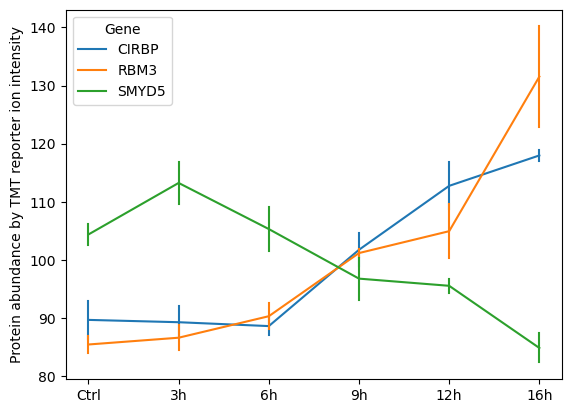

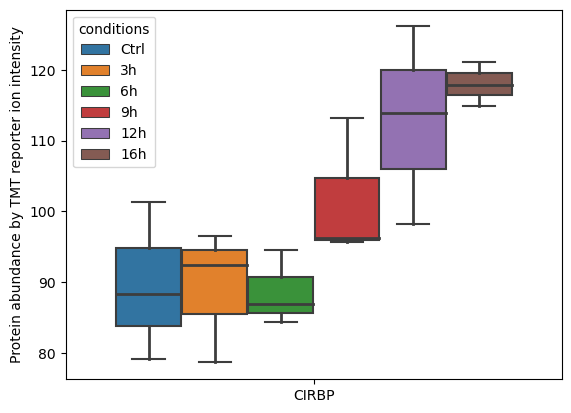

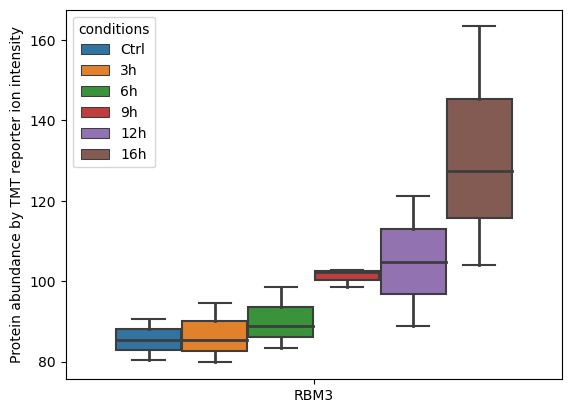

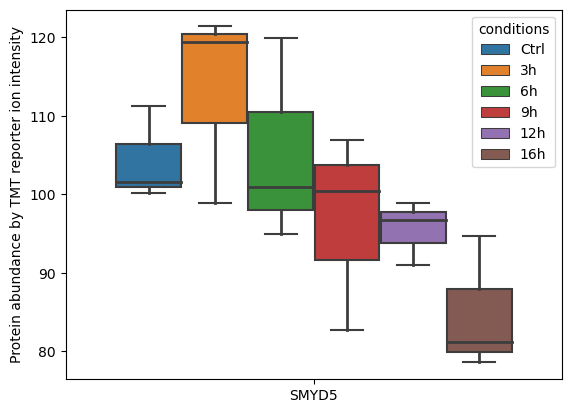

In [51]:
# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

# Print linregess results for the targets
print(df_linregress[(df_linregress['Gene'] == 'CIRBP')|(df_linregress['Gene'] == 'RBM3')
                    |(df_linregress['Gene'] == 'SMYD5')])

seaborn.lineplot(data = df_targets, x='conditions' , y='value', hue= "Gene",
                err_style="bars", errorbar=('se', 0.5))
plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['CIRBP', 'RBM3', 'SMYD5']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Overlap with RNAseq

The overlapping targets are CHORDC1, NOC3L, CIRBP, SRSF5, RBM3 and HNRNPDL

In [ ]:
# Select the overlapping targets and only select expression columns
df_targets =  df[ (df.index == 'CIRBP') | (df.index == 'RBM3') | (df.index == 'SRSF5')
                 | (df.index == 'HNRNPDL') | (df.index == 'CHORDC1') | (df.index == 'NOC3L')]

df_targets

In [ ]:
# Protein expression over time of the overlapped proteins.
## From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()}, \n')

## Print linregess results for the targets
print(df_linregress[(df_linregress.index == 'CIRBP')|(df_linregress.index == 'RBM3')|(df_linregress.index == 'SMYD5')])


## Expression of the target proteins over time
# targets = ['CHORDC1', 'CIRBP', 'SRSF5', 'RBM3', 'HNRNPDL']
targets = ['CHORDC1', 'SRSF5', 'HNRNPDL', 'NOC3L']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Heatmap from expression

### Heatmap Linregress significant proteins only

In [ ]:
# Count number of cells in specific interval to select heatmap vmin/vmax
values = df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)].values.flatten()
bin_edges = numpy.arange(-6, 8, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
# print(count_df.head(3), '\n', count_df.tail(10))
print(count_df)

In [ ]:
# Same but with Linregress significant only
## define the colors, one color per condition 
lut = dict(zip(df_zscore.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_zscore.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)]))

seaborn.clustermap(df_zscore[df_zscore.index.isin(signif_nonAjd_linregress_proteins)], 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

## Only adjusted pvalue

In [ ]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_sign_adjpav = df_zscore[df_zscore.index.isin(adjPvalue_signif_linregress_proteins)]
print(len(df_sign_adjpav), df_sign_adjpav.min().min(), df_sign_adjpav.max().max(), '\n')

values = df_sign_adjpav.values.flatten()
bin_edges = numpy.arange(-4, 5, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

In [ ]:
# Heatmap of proteins expression 
## define the colors, one color per condition 
lut = dict(zip(df_sign_adjpav.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_sign_adjpav.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_sign_adjpav))
seaborn.clustermap(df_sign_adjpav, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-3.5, vmax=3.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

### Heatmap of proteins with rvalue > 0.6 (abs)

In [52]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_high_Rval = df_zscore[df_zscore.index.isin(high_Rval_prot)]
print(len(df_high_Rval), df_high_Rval.min().min(), df_high_Rval.max().max(), '\n')

values = df_high_Rval.values.flatten()
bin_edges = numpy.arange(-6, 7, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

129 -4.310420870711283 5.100283754499261 

    Interval  Count
0   -6 to -5      0
1   -5 to -4      1
2   -4 to -3      0
3   -3 to -2      4
4   -2 to -1     55
5    -1 to 0    347
6     0 to 1    311
7     1 to 2     45
8     2 to 3      7
9     3 to 4      2
10    4 to 5      1
11    5 to 6      1


number of proteins: 129


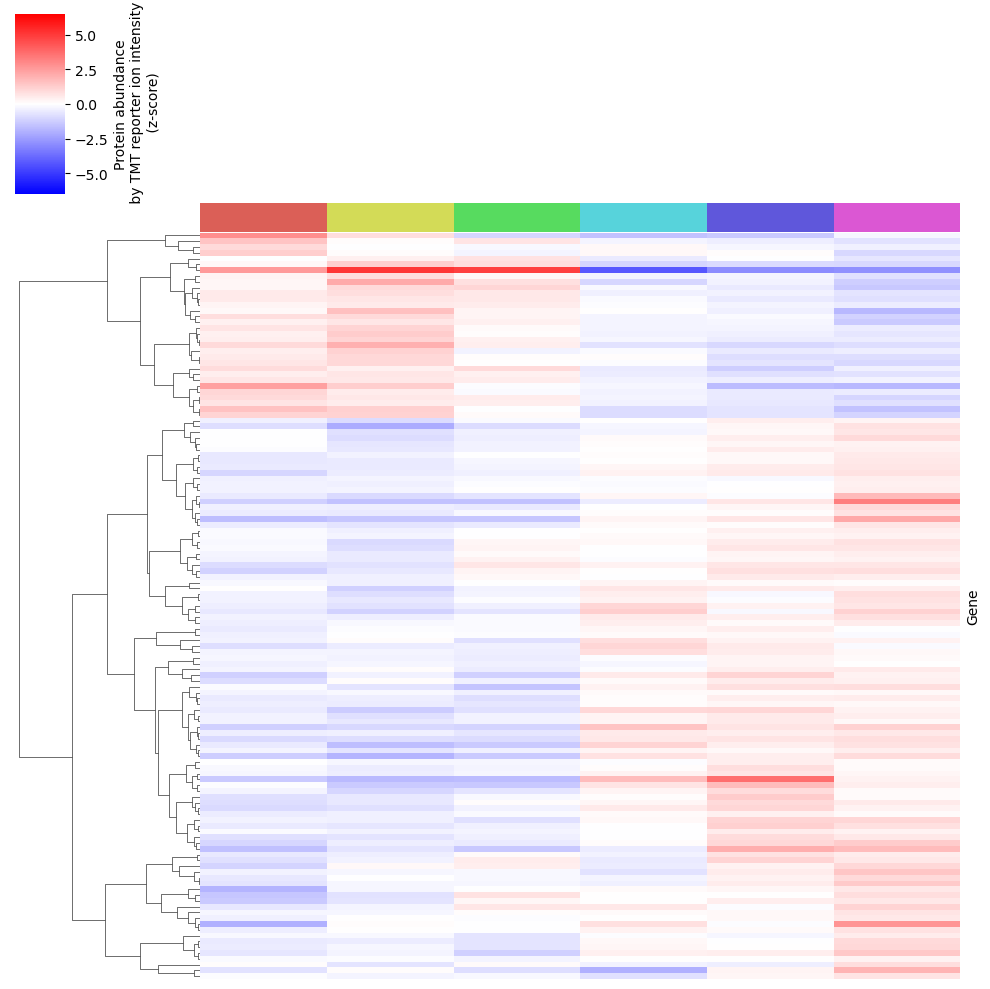

In [53]:
# Heatmap of proteins with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval))
seaborn.clustermap(df_high_Rval, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

In [ ]:
# Heatmap of proteins with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval))
seaborn.clustermap(df_high_Rval, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=False, 
                   vmin=-6.5, vmax=6.5,
                   col_colors = col_colors_conditions,
                   cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                   xticklabels=False, yticklabels=False, 
                   method='complete', metric='cosine')

In [ ]:
# For more detail but not clustered
# plt.subplots(figsize=(8, 30))
# # plt.tight_layout()
# seaborn.heatmap(df_high_Rval, annot=False, cmap="bwr", 
#                 linewidths=0, center=0, vmin=-6.5, vmax=6.5,
#                 cbar_kws={'label': 'Zscore \n protein expression'})

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_zscore)

df_pca = pandas.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_zscore.index)
df_pca.head()

In [ ]:
pc1_mean = df_pca['PC1'].mean()
pc1_std = df_pca['PC1'].std()
pc2_mean = df_pca['PC2'].mean()
pc2_std = df_pca['PC2'].std()

# for standard deviation
threshold = 3

In [ ]:
# Plot the PCA results
# plt.figure(figsize=(10, 7))
plt.scatter(df_pca['PC1'], df_pca['PC2'])

# Annotate points with gene names
for gene in df_pca.index:
    pc1_value = df_pca.loc[gene, 'PC1']
    pc2_value = df_pca.loc[gene, 'PC2']
    
    # Label the outliers
    if (abs(pc1_value - pc1_mean) > threshold * pc1_std) or (abs(pc2_value - pc2_mean) > threshold * pc2_std):
        plt.annotate(gene, (df_pca.loc[gene, 'PC1'], df_pca.loc[gene, 'PC2']))
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of Gene Expression Over Time')

# Cluster

In [ ]:
import scipy.cluster.hierarchy as sch

# Create the dendrogram to determine the optimal clusters
dendrogram = sch.dendrogram(sch.linkage(df_zscore, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Genes')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
# Fit hierarchical clustering with the chosen number of clusters
from sklearn.cluster import AgglomerativeClustering

optimal_clusters = 3
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
df_zscore['Cluster'] = hierarchical.fit_predict(df_zscore)

In [ ]:
# Plot the time series of each cluster
cluster_col = df_zscore.pop('Cluster')
for cluster in range(optimal_clusters):
    cluster_data = df_zscore[cluster_col == cluster]
    for gene in cluster_data.index:
        plt.plot(df_zscore.columns, cluster_data.loc[gene], label=f'Gene {gene}')
        
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Protein Expression')
    plt.legend('')
    plt.show()

# Test 

In [ ]:
for gene in df_zscore.index:
    plt.plot(df_zscore.columns, df_zscore.loc[gene], label=gene)

In [ ]:
# coefficient of variation (CV) of gene expression across time points
cv_expression = df_zscore.std(axis=1) / df_zscore.mean(axis=1)

# Explore distribution of CV values
plt.hist(cv_expression, bins=500)
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of CV Values')
plt.xlim(-100,100)
plt.show()


In [ ]:
threshold = np.percentile(cv_expression, 80)

# Select genes with high coefficient of variation as potential candidates for transient expression
transient_genes = cv_expression[cv_expression > threshold].index.tolist()